# Conv-2: Quantization Experiments

Using _CIFAR-10_ dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
# import tensorflow_model_optimization as tfmot
# from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.3.0


In [3]:
batch_size = 60
num_classes = 10
num_epochs = 100


# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

In [4]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))

X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 1)


In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0


# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [7]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for GradientTape training:

In [8]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [9]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [10]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0002)

In [11]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [12]:
def conv2_cnn():
    # Function to define Conv-2 CNN sequentially

    model = Sequential()

    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
            )
        )
    
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
            )
        )
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
            )
        )
    
    model.add(Flatten())
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotNormal()
            )
        )
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotNormal()
            )
        )
    
    model.add(
        Dense(
            units = 10, activation='softmax'
            )
        )
    

    # Compile defined CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0002),
        metrics=['accuracy']
        )
    
    
    return model



In [13]:
# Load pruned and trained (NOT clustered) model-
pruned_model = conv2_cnn()

In [14]:
# Load pruned weights from before-
pruned_model.load_weights("Conv2_pruned_&_trained_sparsity_86.33.h5")

In [15]:
pruned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4194560   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

In [18]:
orig_params = 4301642

In [17]:
# Sanity check: Count number of trainable parameters in pruned model-
pruned_params = 0

for layer in pruned_model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print(f"layer.shape: {layer.shape} has {loc_params} parameters")
    pruned_params += loc_params

print(f"\nTotal number of trainable parameters in Pruned & Clustered Conv-2 model = {pruned_params}")

layer.shape: (3, 3, 3, 64) has 670 parameters
layer.shape: (64,) has 0 parameters
layer.shape: (3, 3, 64, 64) has 14282 parameters
layer.shape: (64,) has 0 parameters
layer.shape: (16384, 256) has 562960 parameters
layer.shape: (256,) has 0 parameters
layer.shape: (256, 256) has 8797 parameters
layer.shape: (256,) has 0 parameters
layer.shape: (256, 10) has 992 parameters
layer.shape: (10,) has 0 parameters

Total number of trainable parameters in Pruned & Clustered Conv-2 model = 587701


In [21]:
print(f"Conv-2 pruned model has {(orig_params - pruned_params) / orig_params * 100:.2f}% sparsity")

Conv-2 pruned model has 86.34% sparsity


In [22]:
# Get pruned model metrics on validation dataset-
val_loss, val_acc = pruned_model.evaluate(X_test, y_test, verbose = 0)

In [23]:
print("Conv-2 pruned model's metrics on validation dataset are:")
print(f"val_loss = {val_loss:.4f} & val_acc = {val_acc * 100:.2f}%")

Conv-2 pruned model's metrics on validation dataset are:
val_loss = 0.9598 & val_acc = 70.22%


In [24]:
# Make predictions using trained model-
y_pred = pruned_model.predict(X_test)

In [25]:
y_pred = np.argmax(y_pred, axis = 1)
y_test_mod = np.argmax(y_test, axis = 1)

In [26]:
y_pred.shape, y_test_mod.shape

((10000,), (10000,))

In [27]:
acc = accuracy_score(y_true = y_test_mod, y_pred = y_pred)
precision = precision_score(y_true = y_test_mod, y_pred = y_pred, average = 'macro')
recall = recall_score(y_true = y_test_mod, y_pred = y_pred, average = 'macro')

In [28]:
print("\nConv-2 pruned & trained model's validation metrics are:")
print(f"accuracy = {acc:.4f}, precision = {precision:.4f} & recall = {recall:.4f}")


Conv-2 pruned & trained model's validation metrics are:
accuracy = 0.7022, precision = 0.7006 & recall = 0.7022


In [29]:
import pandas as pd
import seaborn as sns

In [30]:
data = {'y_true': y_test_mod,
        'y_pred': y_pred
        }

df = pd.DataFrame(data, columns=['y_true','y_pred'])

In [31]:
confusion_matrix = pd.crosstab(
    df['y_true'], df['y_pred'],
    rownames = ['Ground Truth'], colnames = ['Prediction'],
    margins = True
)

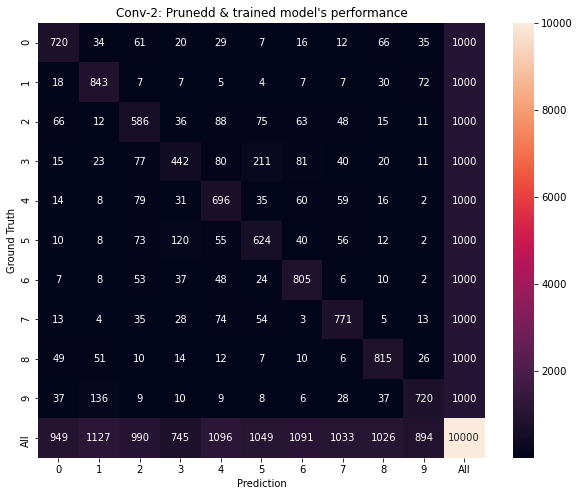

In [32]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = "d")
plt.title("Conv-2: Prunedd & trained model's performance")
plt.show()

### Save the entire model

Call _model.save()_ to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (SavedModel and HDF5). The TensorFlow 'SavedModel' format is the default file format in TF2.x. However, models can be saved in HDF5 format.

*Custom objects (e.g. subclassed models or layers) require special attention when saving and loading. See the Saving custom objects section in this [webpage](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model)


In [33]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model
# model.save('saved_model/my_model')

pruned_model.save("Conv2_Pruned")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Conv2_Pruned\assets


## Post-training Quantization:

### Dynamic range quantization

The simplest form of post-training quantization statically quantizes only the weights from floating point to integer, which has 8-bits of precision-

In [34]:
converter = tf.lite.TFLiteConverter.from_saved_model("Conv2_Pruned")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()

- At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

- To further improve latency, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point so that the speedup with dynamic-range ops is less than a full fixed-point computation.

### Full integer quantization:

You can get further latency improvements, reductions in peak memory usage, and compatibility with integer only hardware devices or accelerators by __making sure all model math is integer quantized__.

- For full integer quantization, you need to calibrate or estimate the range, i.e, (min, max) of all floating-point tensors in the model.

- Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles.

- As a result, the converter requires a _representative dataset_ to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data. Refer to the representative_dataset() function below.


### Integer only:

Creating integer only models is a common use case for TensorFlow Lite for Microcontrollers and Coral Edge TPUs.

Note: Starting TensorFlow 2.3.0, it supports the 'inference_input_type' and 'inference_output_type' attributes.

Additionally, to ensure compatibility with integer only devices (such as 8-bit microcontrollers) and accelerators (such as the Coral Edge TPU), you can enforce full integer quantization for all ops including the input and output, by using the following steps:

```python
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8

tflite_quant_model = converter.convert()
```

__Note:__ The converter will throw an error if it encounters an operation it cannot currently quantize.

In [35]:
def representative_data_gen():
    # for inp_val, _ in test_dataset.take(1):
    for inp_val, _ in test_dataset.batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [inp_val]


### Integer with float fallback (using default float input/output):

In order to fully integer quantize a model, but use float operators when they don't have an integer implementation (to ensure conversion occurs smoothly), use the following steps.

In [36]:
import pathlib

In [38]:
# Using the Python 'TFLiteConverter', you can now convert the trained model into a TensorFlow Lite model.
# Now, convert the model using  'TFliteConverter' into default float32 format-
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

converter = tf.lite.TFLiteConverter.from_saved_model("Conv2_Pruned")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# DON'T USE THE FOLLOWING 2 LINES-
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8

tflite_quant_model = converter.convert()

RuntimeError: tensorflow/lite/kernels/conv.cc:313 input->dims->size != 4 (5 != 4)Node number 0 (CONV_2D) failed to prepare.


In [81]:
# Write it out to a '.tflite' file-
# tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
# tflite_models_dir.mkdir(exist_ok = True, parents = True)
# tflite_model_file = tflite_models_dir/"mnist_model.tflite"
# tflite_model_file.write_bytes(tflite_model)

# tflite_models_dir = pathlib.Path("/home/arjun/Deep_Learning_Resources/Research_Paper-Resources/Codes/")

# tflite_model_file = tflite_models_dir/'model1.tflite'     # model 1 - no optimization nor quantization
# tflite_model_file = tflite_models_dir/'model2.tflite'     # model 2 for optimzation but no quantization
# tflite_model_file = tflite_models_dir/'model3.tflite'     # model 3 for optimzation and quantization
tflite_model_file = tflite_models_dir/'clustered_pruned_model.tflite'     
tflite_model_file.write_bytes(tflite_quant_model)
# 270496
# 270128

# clustered_pruned_model.tflite
# 270480

270480

### Compute validation accuracy:

### Run the TensorFlow Lite models-
Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.

Refer to the tutorial [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant_16x8)

In [82]:
# Load the model into the interpreters-
# interpreter = tf.lite.Interpreter(model_path = str(tflite_model_file))
# interpreter.allocate_tensors()

# tflite_model_file = '/home/arjun/Deep_Learning_Resources/Research_Paper-Resources/Codes/model3.tflite'
tflite_model_file = '/home/arjun/Deep_Learning_Resources/Research_Paper-Resources/Codes/clustered_pruned_model.tflite'

interpreter = tf.lite.Interpreter(model_path = tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

### Test the _trained & quantized_ model on __one image__:


In [83]:
test_image = np.expand_dims(X_test[0], axis = 0).astype(np.float32)

# input_index = interpreter.get_input_details()[0]["index"]
# output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()

predictions = interpreter.get_tensor(output_index)


In [84]:
print(f"Quantized & trained model's prediction = {np.argmax(predictions, axis = 1)}")

Quantized & trained model's prediction = [7]


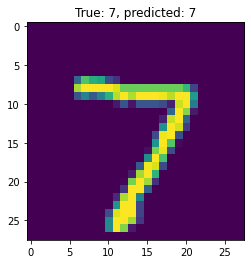

In [85]:
plt.imshow(X_test[0].reshape(28, 28, 1))

template = "True: {true}, predicted: {predict}"

_ = plt.title(template.format(true= str(np.argmax(y_test[0])),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)


In [86]:
test_image.shape

(1, 784)

In [87]:
def evaluate_model(interpreter):
    # Function to evaluate TF Lite model's performance on validation dataset
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the validation dataset.
    prediction_digits = []
    
    for test_image in X_test:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == np.argmax(y_test[index]):
            accurate_count += 1
    
    accuracy = accurate_count * 1.0 / len(prediction_digits)

    return accuracy


In [88]:
val_accuracy = evaluate_model(interpreter)

In [89]:
print(f"TF Lite model's pruned, clustered and quantized val_accuracy = {val_accuracy * 100:.2f}%")
# TF Lite model's quantized val_accuracy = 97.87%

TF Lite model's pruned, clustered and quantized val_accuracy = 97.96%


## Final Step: Zipping

To fully realise the benefit of the pipeline, _zip_ the resulting 'tflite' file and compare it's file size vs. original zipped file.

In [92]:
# File-sizes are in bytes-
orig_model_filesize = 990374
clustered_pruned_tflite_filesize = 17997

In [95]:
print(f"For LeNet-300-100, pipeline resulted in a {orig_model_filesize / clustered_pruned_tflite_filesize:.2f}X reduction")

For LeNet-300-100, pipeline resulted in a 55.03X reduction
